In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
import GW_Routines as GW
import TD_Routines as TD

In [3]:
mpi = 8
omp = 1

## Time dependent analysis 

We study the time evolution of the ground state density subjected to a fast pulse

Choose a value of kpoints and the direction of the perturbing field. Create the fixSymm folder that contain the SAVE folder compatible with the simmetries broken by the perturbation. This folder is working path of the TD simulation.

In [4]:
kfold = 'yambo/k4/'
fieldDirection = [1.0,1.0,1.0]

In [5]:
reload(TD)
path = TD.fixSymm(kfold,fieldDirection)

removed # from RmTimeRev field


In [6]:
path

'yambo/k4//FixSymm'

Create and edit the TD input file. Then run the simulation.

In [10]:
# Field parameters
fieldInt = 1.0E4 #kWLm2
fieldFreq = 1.55 #eV
fieldWidth = 10 #fs

# Simulation parameters
RTstep = 1.0 #as - time step
NETime = 100.0 #fs - total simulation time
RTbands = [1,10] # the KS bands involved in the simulation

nstep = NETime*1e6/RTstep
print 'number of steps : ',nstep 

number of steps :  100000000.0


In [11]:
reload(TD)
rtinput = 'rt.in'
rtoutFold = 'rt-out'
TD.makeTDinput(path,rtinput,fieldDirection,fieldInt,fieldFreq,fieldWidth,RTstep,NETime,RTbands)

In [12]:
TD.runYambo_rt(path,rtinput,rtoutFold,mpi,omp)

execute : cd yambo/k4//FixSymm ; OMP_NUM_THREADS=1 mpirun -np 8 yambo_rt -F rt.in -J rt-out -C rt-out
done!


In [13]:
# parse the output files for data analysis

In [14]:
eFieldOut = 'o-rt-out.external_field'
carriesOut = 'o-rt-out.carriers'

In [15]:
larray = GW.parserArrayFromFile(path+'/rt-out/'+eFieldOut)
time = []
eInt = []
fluence = []
for l in larray:
    time.append(l[0])
    eInt.append(l[7])
    fluence.append(100*l[8])

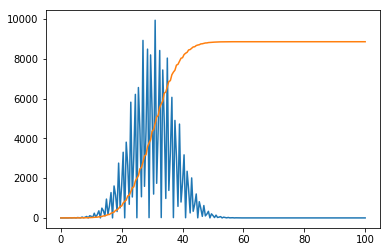

In [16]:
plt.plot(time,eInt)
plt.plot(time,fluence)
plt.show()

In [17]:
larray = GW.parserArrayFromFile(path+'/rt-out/'+carriesOut)
time = []
dnElec = []
dnHoles = []
for l in larray:
    time.append(l[0])
    dnElec.append(l[2])
    dnHoles.append(l[3])

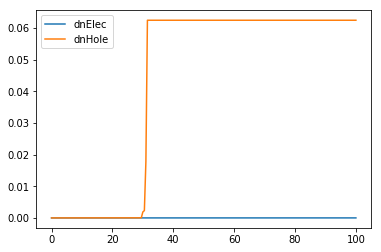

In [18]:
plt.plot(time,dnElec,label='dnElec')
plt.plot(time,dnHoles,label='dnHole')
plt.legend()
plt.show()